# Lab 1 : First order methods on regression models

#### Authors: A. Gramfort, R. Gower, P. Ablin, M. Massias

## Aim

The aim of this material is to code 
- proximal gradient descent (PGD)
- accelerated gradient descent (APGD) 

for 
- linear regression
- logistic regression 

models.

The proximal operators we will use are the 
- L2 penalization
- L1 penalization

## VERY IMPORTANT

- This work **must be done by pairs of students**.
- **Each** student must send their work using the **moodle platform**. Please check the deadline on moodle!
- This means that **each student in the pair sends the same file**
- The **name of the file must be** constructed as in the next cell

# Gentle reminder: no evaluation if you don't respect this EXACTLY

### How to construct the name of your file

In [ ]:
# Change here using YOUR first and last names
fn1 = "Mohamed"
ln1 = "EL FAKIR"
fn2 = "Amine"
ln2 = "ELKARI"

filename = "_".join(map(lambda s: s.strip().lower(), 
                        ["lab1", ln1, fn1, "and", ln2, fn2])) + ".ipynb"
print(filename)

lab1_el fakir_mohamed_and_elkari_amine.ipynb


In [ ]:
## to embed figures in the notebook
%matplotlib inline

## Part 0 : Introduction

We'll start by generating sparse vectors and simulating data

### Getting sparse coefficients

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

np.set_printoptions(precision=2)  # to have simpler print outputs with numpy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  


Text(0.5, 1.0, 'Parameters / Coefficients')

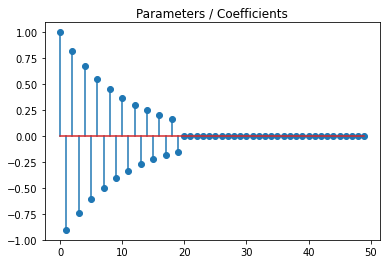

In [ ]:
n_features = 50
n_samples = 1000
idx = np.arange(n_features)
coefs = ((-1) ** idx) * np.exp(-idx / 10.)
coefs[20:] = 0.
plt.stem(coefs)
plt.title("Parameters / Coefficients")

### Functions for the simulation of the models

In [ ]:
from numpy.random import multivariate_normal
from scipy.linalg.special_matrices import toeplitz


def simu_linreg(coefs, n_samples=1000, corr=0.5):
    """Simulation of a linear regression model
    
    Parameters
    ----------
    coefs : `numpy.array`, shape (n_features,)
        Coefficients of the model
    
    n_samples : `int`, default=1000
        Number of samples to simulate
    
    corr : `float`, default=0.5
         Correlation between features i and j is corr^|i - j|


    Returns
    -------
    A : `numpy.ndarray`, shape (n_samples, n_features)
        Simulated features matrix. It samples of a centered Gaussian 
        vector with covariance given by the Toeplitz matrix
    
    b : `numpy.array`, shape (n_samples,)
        Simulated labels
    """
    # Construction of a covariance matrix
    cov = toeplitz(corr ** np.arange(0, n_features))
    # Simulation of features
    A = multivariate_normal(np.zeros(n_features), cov, size=n_samples)
    # Simulation of the labels
    b = A.dot(coefs) + np.random.randn(n_samples)
    return A, b


def sigmoid(t):
    """Sigmoid function"""
    return 1. / (1. + np.exp(-t))


def simu_logreg(coefs, n_samples=1000, corr=0.5):
    """Simulation of a logistic regression model
    
    Parameters
    ----------
    coefs : `numpy.array`, shape (n_features,)
        Coefficients of the model
    
    n_samples : `int`, default=1000
        Number of samples to simulate
    
    corr : `float`, default=0.5
        Correlation between features i and j is corr^|i - j|

    Returns
    -------
    A : `numpy.ndarray`, shape (n_samples, n_features)
        Simulated features matrix. It samples of a centered Gaussian 
        vector with covariance given by the Toeplitz matrix
    
    b : `numpy.array`, shape (n_samples,)
        Simulated labels
    """
    cov = toeplitz(corr ** np.arange(0, n_features))
    A = multivariate_normal(np.zeros(n_features), cov, size=n_samples)
    p = sigmoid(A.dot(coefs))
    b = np.random.binomial(1, p, size=n_samples)
    b = 2 * b - 1
    return A, b

## Generate the data

In [ ]:
A, b = simu_linreg(coefs)
# A, b = simu_logreg(coefs)  # uncomment when you want to test logistic regression

## Part 1 : Proximal operators

We remind that the proximal operator of a function $R$ is given by:

$$
\text{prox}_{(\lambda \,R)}(x) = \arg\min_z \left\{ \frac{1}{2} \Vert x - z\Vert_2^2 + \lambda \,R(z) \right\}.
$$


We have in mind to use the following cases

- L2 penalization, where $R(z) = \frac{1}{2} \|z\|_2^2$
- L1 penalization, where $R(z) =  \|z|\|_1$

where $\lambda > 0$ is a regularization parameter.

<div class="alert alert-success">
    <b>Questions</b>:
     <ul>
      <li>Code a function that computes $R(x)$ in both cases and $\text{prox}_{\lambda\, R}(x)$ for L2 and  L1 penalization (use the slides of the first course to get the formulas), using the prototypes given below</li>
      <li>Visualize the functions applied element wise by the proximity operators of the L2 and L1 
    </li>
    </ul>
</div>

In [ ]:

def prox_L1(x, lmbd):
    """Proximal operator for the L1 at x""" 
    return np.sign(x)*np.maximum(np.abs(x)-lmbd, 0.)       # (x>lmbd)*(x-lmbd) + (x<-lmbd)*(x+lmbd)
    
def L1_norm(x, lmbd):
    """Value of the L1 penalization at x"""
    x=np.sum(abs(x))
    return lmbd*x 

def prox_L2(x, lmbd):
    """Proximal operator for the L2 at x"""    
    return x/(1+lmbd) 
    
def L2_norm(x, lmbd):
    """Value of the L2 penalization at x"""
    x=(lmbd/2)*np.sum(x.T*x)
    return lmbd*x 

In [ ]:
x=np.random.randn(10)
prox_L2(x,0.5)

array([-0.65, -0.76,  0.54, -0.08, -0.21, -0.17, -0.32,  0.21, -0.54,
        0.22])

## Visualization

We are now going to visualize the effect of the proximity operators on coefficients.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This signific

(-2.0, 2.0)

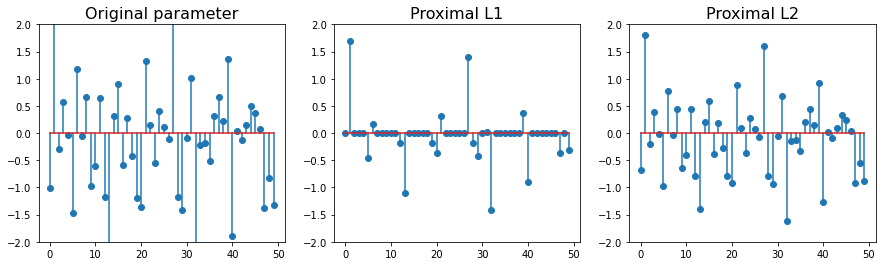

In [ ]:
x = np.random.randn(50)
l_l1 = 1.
l_l2 = 0.5

plt.figure(figsize=(15.0, 4.0))
plt.subplot(1, 3, 1)
plt.stem(x)
plt.title("Original parameter", fontsize=16)
plt.ylim([-2, 2])
plt.subplot(1, 3, 2)
plt.stem(prox_L1(x, lmbd=l_l1))
plt.title("Proximal L1", fontsize=16)
plt.ylim([-2, 2])
plt.subplot(1, 3, 3)
plt.stem(prox_L2(x, lmbd=l_l2))
plt.title("Proximal L2", fontsize=16)
plt.ylim([-2, 2])

<div class="alert alert-success">
    <b>Question</b>:
     <ul>
      <li>Comment what you observe (1 or 2 sentences).</li>
    </ul>
</div>

We can see that the L1 norm penalizes a set of parameters and assigns 0 values to the weights instead of imposing small values as the L2 norm does to the different weights. Consequently, in the case of L1, the problem becomes of very small dimensionality.

## Part 2: Gradients

The problems we want to minimize take the form:
$$
\arg\min_x f(x) + \lambda \,R(x)
$$
where $f$ is $L$-smooth and $R$ has a simple proximal operator.

Consider the following cases:

**Linear regression**, where 
$$
f(x) = \frac{1}{2n} \sum_{i=1}^n (b_i - a_i^\top x)^2 = \frac{1}{2 n} \| b - A x \|_2^2,
$$
where $n$ is the sample size, $b = [b_1 \cdots b_n]$ is the vector of labels and $A = [a_1,\ldots, a_n]^{\top} \in \mathbb{R}^{n \times d}$ is the matrix of samples.

**Logistic regression**, where
$$
f(x) = \frac{1}{n} \sum_{i=1}^n \log(1 + \exp(-b_i a_i^\top x)),
$$
where $n$ is the sample size, and where labels $b_i \in \{ -1, 1 \}$ for all $i$.

We need to be able to compute $f$ and its gradient

<div class="alert alert-success">
    <b>Questions</b>:
     <ul>
      <li>Compute on paper the gradient $\nabla f$ of $f$ for both cases (linear and logistic regression)</li>
      <li>Code a function that computes $f$ and its gradient $\nabla f$ in both cases, using the prototypes below.</li>
      <li>Check that these functions are correct by numerically checking the gradient, using the function ``<a href="https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.check_grad.html">check_grad</a>`` from ``scipy.optimize``. Remark: use the functions `simu_linreg` and `simu_logreg` to simulate data according to the right model</li>
    </ul>
</div>

In [ ]:
A1,b1 = simu_logreg(coefs, n_samples=1000, corr=0.5)
A0,b0 = simu_linreg(coefs, n_samples=1000, corr=0.5)

In [ ]:
n0= len(b0)
n1= len(b1)

def loss_linreg(x):
    """Least-squares loss"""
    # TODO
    f = (1/(2*n0))*np.sum((b0-A0.dot(x).T)@(b0-A0.dot(x)))
    return f

def grad_linreg(x):
    """Leas-squares gradient"""
    # TODO
    #grd = -(1/len(x))*A0.T@(b0-A0@x)
    return (-1/n0) * A0.T@(b0 - np.dot(A0,x))

def loss_logreg(x):
    """Logistic loss"""
    # TODO
    f=0
    for i in range(len(x)):
      f += np.log(1+np.exp(-b1[i]*A1[i]@x))*(1/n1)
    return f

def grad_logreg(x):
    """Logistic gradient"""
    # TODO
    grd= 0
    for i in range(len(x)):
      grd += ((b1[i]*A1[i])/(1+np.exp(b1[i]*(A1[i].T@x))))*(-1/n1) # grd -= (b1[i]/(1+np.exp(b1[i]*A1[i].T@x)))*A[i]*(1/len(x)) 'old one'
    return np.array(grd)

# TO BE COMPLETED

In [ ]:
from scipy.optimize import check_grad
x=np.random.randn(50)

print(check_grad(loss_linreg, grad_linreg,np.array(x)),check_grad(loss_logreg, grad_logreg, np.array(x)))

1.601118045894952e-06 1.4174101534347043e-08


## Part 3: Solvers

We know have a function to compute $f$, $\nabla f$ and $R$ and $\text{prox}_R$. 

We want now to code the PGD and APGD solvers to minimize

$$
\arg\min_x f(x) + \lambda \, R(x)
$$

where $\lambda >0$ is the regularization parameter

<div class="alert alert-success">
    <b>Questions</b>:
     <ul>
      <li>Implement functions that compute the Lipschitz constants for linear and 
  logistic regression losses. Note that the operator norm of a matrix can 
  be computed using the function <a href="https://docs.scipy.org/doc/numpy/reference/generated/numpy.linalg.norm.html">numpy.linalg.norm</a> (read the documentation
  of the function)</li>
      <li>Finish the functions `PGD` and `APGD` below that implements the 
  PGD(Proximal Gradient Descent) and APGD (Accelerated Proximal 
  Gradient Descent) algorithms</li>
    </ul>
</div>

In [ ]:
# TO BE COMPLETED

from numpy.linalg import norm
# Calculate the smoothness constant for L2 + L2 regularizor
def smoothness_const_linreg(A):
    """Lipschitz constant for linear squares loss"""    
    return np.linalg.norm(A.T@A, ord = 2)*1/len(A)

# Calculate the smoothness constant for Logistic loss + L2 regularizor    
def smoothness_const_loreg(A):
    """Lipschitz constant for logistic loss"""    
    return np.linalg.norm(A.T@A, ord = 2)*(1/4)*(1/len(A))
    
def PGD(x0, f, grad_f, R, prox_R, step, lmbd=0., n_iter=50,
         x_true=coefs, verbose=True):
    """Proximal gradient descent algorithm
    """
    x = x0.copy()
    x_new = x0.copy()
    n_samples, n_features = A.shape

    # estimation error history
    errors = []
    # objective history
    objectives = []
    # Current estimation error
    err = norm(x - x_true) / norm(x_true)
    errors.append(err)
    # Current objective
    obj = f(x) + R(x, lmbd)
    objectives.append(obj)
    if verbose:
        print("Lauching PGDsolver...")
        print(' | '.join([name.center(8) for name in ["it", "obj", "err"]]))
    for k in range(n_iter + 1):

        #### TODO ####     
        x = prox_R(x - step*grad_f(x), lmbd)
        obj = f(x) + R(x, lmbd)
        err = norm(x - x_true) / norm(x_true)
        errors.append(err)
        objectives.append(obj)
        if k % 10 == 0 and verbose:
            print(' | '.join([("%d" % k).rjust(8), 
                              ("%.2e" % obj).rjust(8), 
                              ("%.2e" % err).rjust(8)]))
    return x, objectives, errors

In [ ]:
# TO BE COMPLETED

def APGD(x0, f, grad_f, R, prox_R, step, lmbd=0., n_iter=50,
         x_true=coefs, verbose=True):
    """Accelerated Proximal gradient descent algorithm
    """
    x = x0.copy()
    x_new = x0.copy()
    # An extra variable is required for APGD
    z = x0.copy()
    n_samples, n_features = A.shape
    # estimation error history
    errors = []
    # objective history
    objectives = []
    # Current estimation error
    err = norm(x - x_true) / norm(x_true)
    errors.append(err)
    # Current objective
    obj = f(x) + R(x, lmbd)
    objectives.append(obj)
    t = 1.
    t_new = 1.   
    beta = 1
    z = x0.copy()
    if verbose:
        print("Lauching APGD solver...")
        print(' | '.join([name.center(8) for name in ["it", "obj", "err"]]))
    for k in range(n_iter + 1):
        #### TODO ####
        x_new = prox_R(z - step*grad_f(z), lmbd)
        beta_new = 1 + np.sqrt(1+4*(beta**2))*(1/2)
        z_new = x_new + ((beta-1)/beta_new)*(x_new - x)
        x = x_new
        beta = beta_new
        z = z_new
        obj = f(x) + R(x, lmbd)
        err = norm(x - x_true) / norm(x_true)
        errors.append(err)
        objectives.append(obj)
        if k % 10 == 0 and verbose:
            print(' | '.join([("%d" % k).rjust(8), 
                              ("%.2e" % obj).rjust(8), 
                              ("%.2e" % err).rjust(8)]))
    return x, np.array(objectives), np.array(errors)

## Algorithms comparison and numerical experiments

In [ ]:
# Some definitions before launching the algorithms
x0 = np.zeros(n_features)
n_iter = 200
lmbd = 1e-2

<div class="alert alert-success">
    <b>Questions</b>:
     <ul>
      <li>Compute a precise minimum and a precise minimizer of the linear regression with L2 
  penalization problem using the parameters give above. This can be done by using APGD with 
  1000 iterations.</li>
    <li>Compare the convergences of PGD and APGD, in terms of distance to the minimum and 
  distance to the minimizer. Do your plots using a logarithmic scale of the y-axis.</li>
    </ul>
</div>

<div class="alert alert-success">
    <b>Answer</b>:
     <ul> 1. Compute a precise minimum and a precise minimizer of the linear regression with L2 penalization problem using the parameters give above. This can be done by using APGD with 1000 iterations.</ul>
</div>

In [ ]:
#Simulation for linear regression

L = smoothness_const_linreg(A0)

#Applying APGD Algorithm
x_m, obj_m, err_t = APGD(x0, loss_linreg, grad_linreg, L2_norm, prox_L2, 1/L, lmbd=lmbd, n_iter =1000,x_true=coefs, verbose=True)

#Minimum and minimizer :
minimizer = x_m
minimum = obj_m[-1]
print("Minimizer : ",minimizer,'\n','Minimum : ' ,minimum)

Lauching APGD solver...
   it    |   obj    |   err   
       0 | 1.19e+00 | 8.87e-01
      10 | 4.56e-01 | 1.14e-01
      20 | 4.65e-01 | 1.51e-01
      30 | 4.60e-01 | 1.34e-01
      40 | 4.62e-01 | 1.39e-01
      50 | 4.61e-01 | 1.37e-01
      60 | 4.62e-01 | 1.38e-01
      70 | 4.62e-01 | 1.38e-01
      80 | 4.62e-01 | 1.38e-01
      90 | 4.62e-01 | 1.38e-01
     100 | 4.62e-01 | 1.38e-01
     110 | 4.62e-01 | 1.38e-01
     120 | 4.62e-01 | 1.38e-01
     130 | 4.62e-01 | 1.38e-01
     140 | 4.62e-01 | 1.38e-01
     150 | 4.62e-01 | 1.38e-01
     160 | 4.62e-01 | 1.38e-01
     170 | 4.62e-01 | 1.38e-01
     180 | 4.62e-01 | 1.38e-01
     190 | 4.62e-01 | 1.38e-01
     200 | 4.62e-01 | 1.38e-01
     210 | 4.62e-01 | 1.38e-01
     220 | 4.62e-01 | 1.38e-01
     230 | 4.62e-01 | 1.38e-01
     240 | 4.62e-01 | 1.38e-01
     250 | 4.62e-01 | 1.38e-01
     260 | 4.62e-01 | 1.38e-01
     270 | 4.62e-01 | 1.38e-01
     280 | 4.62e-01 | 1.38e-01
     290 | 4.62e-01 | 1.38e-01
     300 | 4.62

<div class="alert alert-success">
    <b>Answer</b>:
     <ul> 2. Compare the convergences of PGD and APGD, in terms of distance to the minimum and distance to the minimizer. Do your plots using a logarithmic scale of the y-axis.
    </ul>
</div>

**The distance with the minimizer is given by the error**

Lauching PGDsolver...
   it    |   obj    |   err   
       0 | 1.19e+00 | 8.87e-01
      10 | 5.49e-01 | 3.54e-01
      20 | 4.79e-01 | 2.04e-01
      30 | 4.66e-01 | 1.59e-01
      40 | 4.63e-01 | 1.45e-01
      50 | 4.62e-01 | 1.40e-01
      60 | 4.62e-01 | 1.39e-01
      70 | 4.62e-01 | 1.38e-01
      80 | 4.62e-01 | 1.38e-01
      90 | 4.62e-01 | 1.38e-01
     100 | 4.62e-01 | 1.38e-01
     110 | 4.62e-01 | 1.38e-01
     120 | 4.62e-01 | 1.38e-01
     130 | 4.62e-01 | 1.38e-01
     140 | 4.62e-01 | 1.38e-01
     150 | 4.62e-01 | 1.38e-01
     160 | 4.62e-01 | 1.38e-01
     170 | 4.62e-01 | 1.38e-01
     180 | 4.62e-01 | 1.38e-01
     190 | 4.62e-01 | 1.38e-01
     200 | 4.62e-01 | 1.38e-01
Lauching APGD solver...
   it    |   obj    |   err   
       0 | 1.19e+00 | 8.87e-01
      10 | 4.56e-01 | 1.14e-01
      20 | 4.65e-01 | 1.51e-01
      30 | 4.60e-01 | 1.34e-01
      40 | 4.62e-01 | 1.39e-01
      50 | 4.61e-01 | 1.37e-01
      60 | 4.62e-01 | 1.38e-01
      70 | 4.62e-01 | 1.

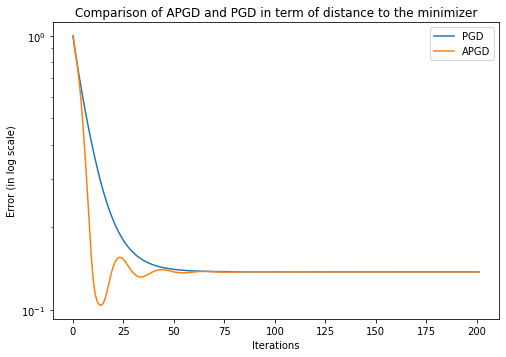

In [ ]:
pgd = PGD(x0, loss_linreg, grad_linreg, L2_norm, prox_L2, 1/L, lmbd=lmbd, n_iter = n_iter,x_true=coefs, verbose=True)
apgd = APGD(x0, loss_linreg, grad_linreg, L2_norm, prox_L2, 1/L, lmbd=lmbd, n_iter = n_iter,x_true=coefs, verbose=True)

fig = plt.figure(figsize=(8,12))
ax = fig.add_subplot(2, 1, 1)
ax.plot(pgd[2],label = "PGD")
ax.plot(apgd[2],label = "APGD")
ax.set_yscale('log')
plt.legend()
plt.xlabel("Iterations")
plt.ylabel("Error (in log scale)")
plt.title("Comparison of APGD and PGD in term of distance to the minimizer")
plt.show()

Conclusion : We can observe as expected that the APGD algorithm converges faster in term of distance to the minimizer.

**The distance to the minimum is given by comparing the true minimum (by using the coefficients in our loss function f(coeffs)) with the objective function obtained by our algorithms.**

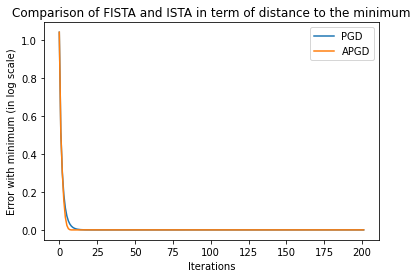

In [ ]:
#Creation of the theoretical minimum.
true_obj = loss_linreg(coefs)+ L2_norm(coefs,lmbd)

#Creation of the error
diff_pgd = [(pgd[1][j] - true_obj)**2 for j in range(len(pgd[1]))]
diff_apgd = [(apgd[1][j] - true_obj)**2 for j in range(len(apgd[1]))]

#Creation of the figure

plt.plot(diff_pgd, label = "PGD")
plt.plot(diff_apgd, label = "APGD")
ax.set_yscale('log')
plt.legend()
plt.xlabel("Iterations")
plt.ylabel("Error with minimum (in log scale)")
plt.title("Comparison of FISTA and ISTA in term of distance to the minimum")
plt.show()

Conclusion : We have the same conclusions mentioned before; APGD algorithm is faster than PGD

<div class="alert alert-success">
    <b>EXERCISE</b>:
     <ul>
      <li>Compare the solution you obtain with PGD and APGD with the true parameter `coefs` of
  the model. This can be done with 3 `plt.stem` plots. Do this for one problem (linear or logistic), but for both regularizers. Comment.</li>
    <li> Pick one problem (logistic or linear) and regularizer (L1 or L2), and study the influence of the correlation 
  of the features on the performance of the optimization algorithms. Explain.</li>
    <li>Pick a different problem (logistic or linear) and a different regularization (L1 or L2), and study the influence of the level of  
  penalization ($\lambda$) on the performance of the optimization algorithms. Explain. Analyse and explain the behavior of the solution vector when $\lambda$ increases.</li>
    </ul>
</div>

<div class="alert alert-success">
    <b>Answer</b>:
     <ul>1.
      Compare the solution you obtain with PGD and APGD with the true parameter `coefs` of
  the model. This can be done with 3 `plt.stem` plots. Do this for one problem (linear or logistic), but for both regularizers. Comment.


</div>

Lauching PGDsolver...
   it    |   obj    |   err   
       0 | 1.19e+00 | 8.85e-01
      10 | 5.44e-01 | 3.47e-01
      20 | 4.77e-01 | 1.99e-01
      30 | 4.65e-01 | 1.56e-01
      40 | 4.63e-01 | 1.43e-01
      50 | 4.62e-01 | 1.39e-01
      60 | 4.61e-01 | 1.37e-01
      70 | 4.61e-01 | 1.37e-01
      80 | 4.61e-01 | 1.37e-01
      90 | 4.61e-01 | 1.37e-01
     100 | 4.61e-01 | 1.37e-01
     110 | 4.61e-01 | 1.37e-01
     120 | 4.61e-01 | 1.37e-01
     130 | 4.61e-01 | 1.37e-01
     140 | 4.61e-01 | 1.37e-01
     150 | 4.61e-01 | 1.37e-01
     160 | 4.61e-01 | 1.37e-01
     170 | 4.61e-01 | 1.37e-01
     180 | 4.61e-01 | 1.37e-01
     190 | 4.61e-01 | 1.37e-01
     200 | 4.61e-01 | 1.37e-01
Lauching APGD solver...
   it    |   obj    |   err   
       0 | 1.19e+00 | 8.85e-01
      10 | 4.56e-01 | 1.13e-01
      20 | 4.65e-01 | 1.50e-01
      30 | 4.60e-01 | 1.33e-01
      40 | 4.62e-01 | 1.38e-01
      50 | 4.61e-01 | 1.36e-01
      60 | 4.61e-01 | 1.37e-01
      70 | 4.61e-01 | 1.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  from ipykernel import kernelapp as app
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of in

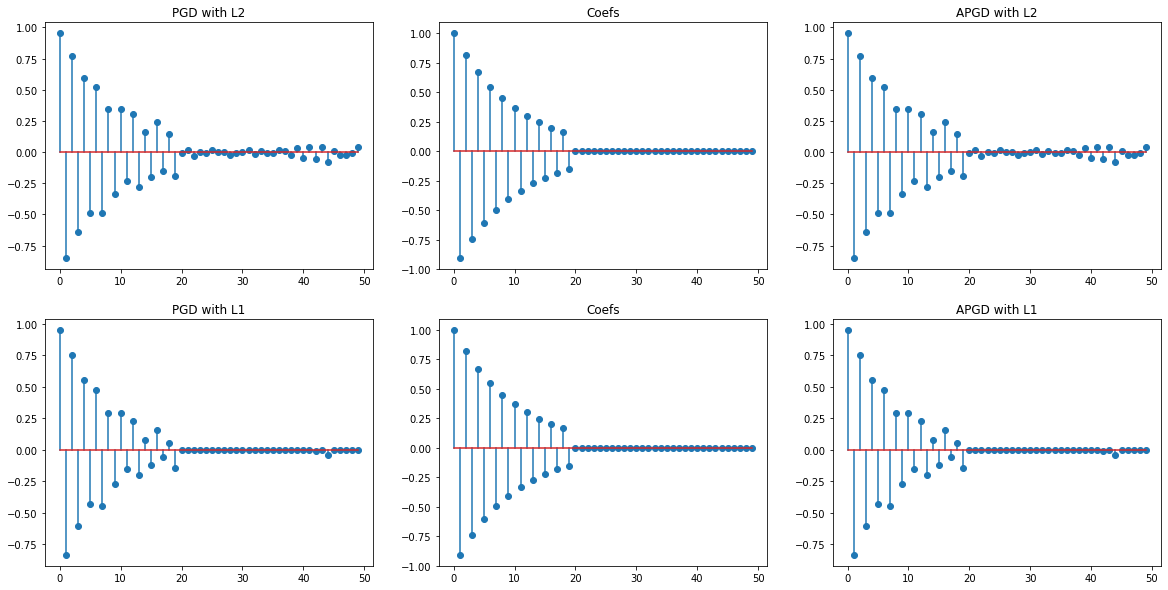

In [ ]:
L = smoothness_const_linreg(A1)

pgd = PGD(x0, loss_linreg, grad_linreg, L2_norm, prox_L2, 1/L, lmbd=lmbd, n_iter = n_iter,x_true=coefs, verbose=True)
apgd = APGD(x0, loss_linreg, grad_linreg, L2_norm, prox_L2, 1/L, lmbd=lmbd, n_iter = n_iter,x_true=coefs, verbose=True)

pgd_l1 = PGD(x0, loss_linreg, grad_linreg, L1_norm, prox_L1, 1/L, lmbd=lmbd, n_iter = n_iter,x_true=coefs, verbose=True)
apgd_l1 = APGD(x0, loss_linreg, grad_linreg, L1_norm, prox_L1, 1/L, lmbd=lmbd, n_iter = n_iter,x_true=coefs, verbose=True)

fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(2, 3, 1)
ax.stem(pgd[0])
ax.set_title('PGD with L2')
ax = fig.add_subplot(2, 3, 2)
ax.set_title('Coefs')
ax.stem(coefs)
ax = fig.add_subplot(2, 3, 3)
ax.set_title('APGD with L2')
ax.stem(apgd[0])
ax = fig.add_subplot(2, 3, 4)
ax.stem(pgd_l1[0])
ax.set_title('PGD with L1')
ax = fig.add_subplot(2, 3, 5)
ax.set_title('Coefs')
ax.stem(coefs)
ax = fig.add_subplot(2, 3, 6)
ax.set_title('APGD with L1')
ax.stem(apgd_l1[0])

plt.show()

Conclusion & explanation: For a linear problem with L2 regularization, we can see that the null coefficients are not null in our estimation, just the magnitude of the coefficients is reduced. On the contrary for a linear problem with L1 regularization, we can see that the null weights for the coefficients are almost null in our estimation. Otherwise, the coefficients are reduced by both regularizations but more aggressively for L1. The effect of the regularization does not change between PGD and APGD.

<div class="alert alert-success">
    <b>Answer</b>:
     <ul> 2. Pick one problem (logistic or linear) and regularizer (L1 or L2), and study the influence of the correlation 
  of the features on the performance of the optimization algorithms. Explain.</
    </ul>
</div>

Lauching APGD solver...
   it    |   obj    |   err   
       0 | 1.17e+00 | 6.31e-01
      10 | 4.65e-01 | 9.41e-02
      20 | 4.64e-01 | 9.29e-02
      30 | 4.64e-01 | 9.29e-02
      40 | 4.64e-01 | 9.29e-02
      50 | 4.64e-01 | 9.29e-02
      60 | 4.64e-01 | 9.29e-02
      70 | 4.64e-01 | 9.29e-02
      80 | 4.64e-01 | 9.29e-02
      90 | 4.64e-01 | 9.29e-02
     100 | 4.64e-01 | 9.29e-02
     110 | 4.64e-01 | 9.29e-02
     120 | 4.64e-01 | 9.29e-02
     130 | 4.64e-01 | 9.29e-02
     140 | 4.64e-01 | 9.29e-02
     150 | 4.64e-01 | 9.29e-02
Lauching APGD solver...
   it    |   obj    |   err   
       0 | 1.38e+00 | 8.24e-01
      10 | 4.61e-01 | 1.30e-01
      20 | 4.67e-01 | 1.11e-01
      30 | 4.66e-01 | 1.11e-01
      40 | 4.65e-01 | 1.11e-01
      50 | 4.65e-01 | 1.11e-01
      60 | 4.65e-01 | 1.11e-01
      70 | 4.65e-01 | 1.11e-01
      80 | 4.65e-01 | 1.11e-01
      90 | 4.65e-01 | 1.11e-01
     100 | 4.65e-01 | 1.11e-01
     110 | 4.65e-01 | 1.11e-01
     120 | 4.65e-01 | 

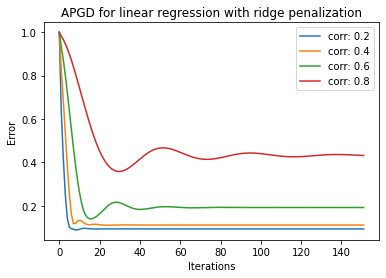

In [ ]:
#Performance of APGD algorithm on linear regression
n_iter = 150
#We calculate the Lipschitz constants also

# Implementation of differents APGD according to the correlation value we precise on the generated data
A0, b0 = simu_linreg(coefs, n_samples=1000, corr=0.2)
L_02 = smoothness_const_linreg(A0)
APGD_02 = APGD(x0, loss_linreg, grad_linreg, L2_norm, prox_L2, 1/L_02, lmbd=lmbd, n_iter = n_iter,x_true=coefs, verbose=True)

A0, b0 = simu_linreg(coefs, n_samples=1000, corr=0.4)
L_04 = smoothness_const_linreg(A0)
APGD_04 = APGD(x0, loss_linreg, grad_linreg, L2_norm, prox_L2, 1/L_04, lmbd=lmbd, n_iter = n_iter,x_true=coefs, verbose=True)

A0, b0 = simu_linreg(coefs, n_samples=1000, corr=0.6)
L_06 = smoothness_const_linreg(A0)
APGD_06 = APGD(x0, loss_linreg, grad_linreg, L2_norm, prox_L2, 1/L_06, lmbd=lmbd, n_iter = n_iter,x_true=coefs, verbose=True)

A0, b0 = simu_linreg(coefs, n_samples=1000, corr=0.8)
L_08 = smoothness_const_linreg(A0)
APGD_08 = APGD(x0, loss_linreg, grad_linreg, L2_norm, prox_L2, 1/L_08, lmbd=lmbd, n_iter = n_iter,x_true=coefs, verbose=True)


x = np.arange(len(APGD_02[1]))
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
plt.plot(x, APGD_02[2], label = 'corr: 0.2')
plt.plot(x, APGD_04[2], label = 'corr: 0.4')
plt.plot(x, APGD_06[2], label = 'corr: 0.6')
plt.plot(x, APGD_08[2], label = 'corr: 0.8')
plt.xlabel('Iterations')
plt.ylabel('Error')


plt.title('APGD for linear regression with ridge penalization')
plt.legend()
plt.show()

Lauching APGD solver...
   it    |   obj    |   err   
       0 | 3.31e-02 | 9.94e-01
      10 | 1.99e-02 | 9.42e-01
      20 | 1.39e-02 | 9.62e-01
      30 | 1.25e-02 | 9.74e-01
      40 | 1.32e-02 | 9.51e-01
      50 | 1.41e-02 | 9.39e-01
      60 | 1.41e-02 | 9.44e-01
      70 | 1.36e-02 | 9.53e-01
      80 | 1.35e-02 | 9.53e-01
      90 | 1.36e-02 | 9.47e-01
     100 | 1.38e-02 | 9.45e-01
     110 | 1.37e-02 | 9.47e-01
     120 | 1.36e-02 | 9.50e-01
     130 | 1.36e-02 | 9.50e-01
     140 | 1.37e-02 | 9.48e-01
     150 | 1.37e-02 | 9.47e-01
Lauching APGD solver...
   it    |   obj    |   err   
       0 | 3.36e-02 | 9.96e-01
      10 | 2.23e-02 | 9.48e-01
      20 | 1.63e-02 | 9.41e-01
      30 | 1.46e-02 | 9.41e-01
      40 | 1.52e-02 | 9.28e-01
      50 | 1.61e-02 | 9.22e-01
      60 | 1.63e-02 | 9.26e-01
      70 | 1.59e-02 | 9.31e-01
      80 | 1.56e-02 | 9.32e-01
      90 | 1.57e-02 | 9.28e-01
     100 | 1.59e-02 | 9.25e-01
     110 | 1.59e-02 | 9.26e-01
     120 | 1.58e-02 | 

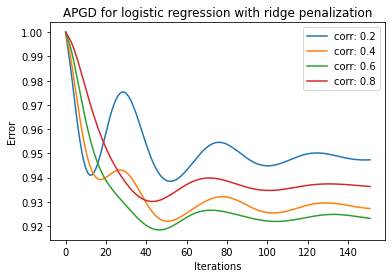

In [ ]:
#Performance of APGD algorithm on logistic regression
n_iter = 150
#We calculate the Lipschitz constants also

# Implementation of differents APGD according to the correlation value we precise on the generated data
A0, b0 = simu_logreg(coefs, n_samples=1000, corr=0.2)
L_02 = smoothness_const_loreg(A0)
APGD_02 = APGD(x0, loss_logreg, grad_logreg, L2_norm, prox_L2, 1/L_02, lmbd=lmbd, n_iter = n_iter,x_true=coefs, verbose=True)

A0, b0 = simu_logreg(coefs, n_samples=1000, corr=0.4)
L_04 = smoothness_const_loreg(A0)
APGD_04 = APGD(x0, loss_logreg, grad_logreg, L2_norm, prox_L2, 1/L_04, lmbd=lmbd, n_iter = n_iter,x_true=coefs, verbose=True)

A0, b0 = simu_logreg(coefs, n_samples=1000, corr=0.6)
L_06 = smoothness_const_loreg(A0)
APGD_06 = APGD(x0, loss_logreg, grad_logreg, L2_norm, prox_L2, 1/L_06, lmbd=lmbd, n_iter = n_iter,x_true=coefs, verbose=True)

A0, b0 = simu_logreg(coefs, n_samples=1000, corr=0.8)
L_08 = smoothness_const_loreg(A0)
APGD_08 = APGD(x0, loss_logreg, grad_logreg, L2_norm, prox_L2, 1/L_08, lmbd=lmbd, n_iter = n_iter,x_true=coefs, verbose=True)


x = np.arange(len(APGD_02[1]))
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
plt.plot(x, APGD_02[2], label = 'corr: 0.2')
plt.plot(x, APGD_04[2], label = 'corr: 0.4')
plt.plot(x, APGD_06[2], label = 'corr: 0.6')
plt.plot(x, APGD_08[2], label = 'corr: 0.8')
plt.xlabel('Iterations')
plt.ylabel('Error')


plt.title('APGD for logistic regression with ridge penalization')
plt.legend()
plt.show()

Conclusion : We can see that when we have a high correlation between our independent variables, our error tends to be larger, therefore depending on the convergence rate the algorithm becomes slower when the correlation is higher.

<div class="alert alert-success">
    <b>Explanation</b>:
     <ul> By looking for the reasons of this relation between the correlation, the speed and the error. We return to the theoretical formulas and look for where the correlation intervenes, it results that the term responsible for this relation is the smoothness constant (we find it on the upper bound of our inequalities of error and convergence rate) since it contains the product of the matrices A.T and A. And since a big correlation results in a big variance, this explains that 1/L is smaller, so the algorithm becomes less fast as shown in the figures. Also the distance between the optimal solution and the loss function value at a given iteration is proportional to L which implies a larger error if L is large.
    </ul>
</div>

<div class="alert alert-success">
    <b>Answer</b>:
     <ul>3. Pick a different problem (logistic or linear) and a different regularization (L1 or L2), and study the influence of the level of  
  penalization ($\lambda$) on the performance of the optimization algorithms. Explain. Analyse and explain the behavior of the solution vector when $\lambda$ increases.
    </ul>
</div>

Lauching APGD solver...
   it    |   obj    |   err   
       0 | 3.36e-02 | 9.95e-01
      10 | 2.27e-02 | 9.40e-01
      20 | 1.68e-02 | 9.50e-01
      30 | 1.33e-02 | 1.05e+00
      40 | 1.11e-02 | 1.23e+00
      50 | 9.61e-03 | 1.45e+00
      60 | 8.49e-03 | 1.70e+00
      70 | 7.65e-03 | 1.95e+00
      80 | 7.06e-03 | 2.20e+00
      90 | 6.66e-03 | 2.44e+00
     100 | 6.41e-03 | 2.68e+00
     110 | 6.26e-03 | 2.89e+00
     120 | 6.18e-03 | 3.10e+00
     130 | 6.14e-03 | 3.28e+00
     140 | 6.14e-03 | 3.45e+00
     150 | 6.16e-03 | 3.61e+00
Lauching APGD solver...
   it    |   obj    |   err   
       0 | 3.39e-02 | 9.96e-01
      10 | 2.64e-02 | 9.36e-01
      20 | 2.34e-02 | 9.03e-01
      30 | 2.28e-02 | 9.21e-01
      40 | 2.27e-02 | 9.59e-01
      50 | 2.28e-02 | 1.00e+00
      60 | 2.30e-02 | 1.05e+00
      70 | 2.31e-02 | 1.07e+00
      80 | 2.32e-02 | 1.08e+00
      90 | 2.32e-02 | 1.08e+00
     100 | 2.31e-02 | 1.07e+00
     110 | 2.31e-02 | 1.05e+00
     120 | 2.30e-02 | 

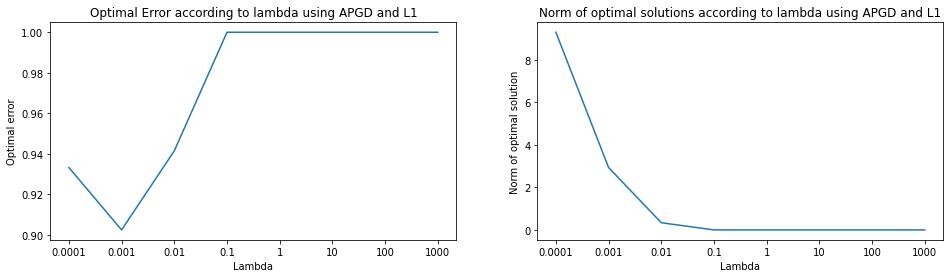

In [ ]:
#Performance of APGD algorithm on logistic regression
n_iter = 150
#set of our lambda values
lmbd1 = ['0.0001','0.001','0.01','0.1','1','10','100','1000']

# Implementation of differents APGD according to the correlation value we precise on the generated data
A1, b1 = simu_logreg(coefs, n_samples=1000, corr=0.4)
L = smoothness_const_loreg(A1)
weights = []
error = []
for i in range(len(lmbd1)) :
    apgd_t = APGD(x0, loss_logreg, grad_logreg, L1_norm, prox_L1, 1/L, lmbd=float(lmbd1[i]), n_iter = n_iter, x_true=coefs, verbose=True)
    error += [min(apgd_t[2])] 
    weights += [norm(apgd_t[0])] 

fig = plt.figure(figsize=(16,4))
ax = fig.add_subplot(1,2,1)
plt.plot(lmbd1,error)
plt.xlabel('Lambda')
plt.ylabel('Optimal error')
plt.title('Optimal Error according to lambda using APGD and L1')
ax = fig.add_subplot(1,2,2)
plt.plot(lmbd1,weights)
plt.xlabel('Lambda')
plt.ylabel('Norm of optimal solution')

plt.title('Norm of optimal solutions according to lambda using APGD and L1')


plt.show()

Conclusion & explanation: We can see that once the lambda value exceeds 0.001, the optimal error of our problem becomes more significant. This is due to the fact that the problem tends to minimize the norm of the weights to the maximum which generates a cancelation of the weights once the lambda value is large enough

Lauching APGD solver...
   it    |   obj    |   err   
       0 | 3.35e-02 | 9.95e-01
      10 | 2.19e-02 | 9.39e-01
      20 | 1.55e-02 | 9.61e-01
      30 | 1.17e-02 | 1.08e+00
      40 | 9.01e-03 | 1.29e+00
      50 | 7.05e-03 | 1.54e+00
      60 | 5.54e-03 | 1.80e+00
      70 | 4.37e-03 | 2.07e+00
      80 | 3.48e-03 | 2.34e+00
      90 | 2.83e-03 | 2.59e+00
     100 | 2.35e-03 | 2.82e+00
     110 | 1.99e-03 | 3.02e+00
     120 | 1.71e-03 | 3.21e+00
     130 | 1.51e-03 | 3.36e+00
     140 | 1.36e-03 | 3.50e+00
     150 | 1.24e-03 | 3.60e+00
Lauching APGD solver...
   it    |   obj    |   err   
       0 | 3.35e-02 | 9.95e-01
      10 | 2.19e-02 | 9.39e-01
      20 | 1.57e-02 | 9.55e-01
      30 | 1.21e-02 | 1.05e+00
      40 | 9.79e-03 | 1.19e+00
      50 | 8.24e-03 | 1.34e+00
      60 | 7.20e-03 | 1.46e+00
      70 | 6.57e-03 | 1.55e+00
      80 | 6.29e-03 | 1.59e+00
      90 | 6.25e-03 | 1.59e+00
     100 | 6.38e-03 | 1.57e+00
     110 | 6.63e-03 | 1.52e+00
     120 | 6.94e-03 | 

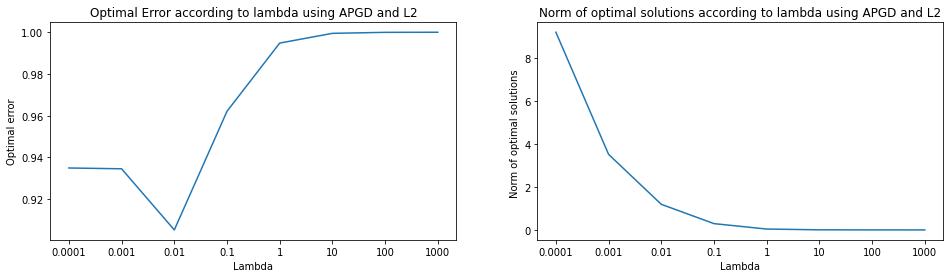

In [ ]:
#Performance of APGD algorithm on linear regression
n_iter = 150
#set of our lambda values
lmbd1 = ['0.0001','0.001','0.01','0.1','1','10','100','1000']

# Implementation of differents APGD according to the correlation value we precise on the generated data
A0, b0 = simu_logreg(coefs, n_samples=1000, corr=0.4)
L = smoothness_const_loreg(A0)

weights = []
error = []
for i in range(len(lmbd1)) :
    apgd_t = APGD(x0, loss_logreg, grad_logreg, L2_norm, prox_L2, 1/L, lmbd=float(lmbd1[i]), n_iter = n_iter,x_true=coefs, verbose=True)
    error += [min(apgd_t[2])] 
    weights += [norm(apgd_t[0])] 
    
fig = plt.figure(figsize=(16,4))
ax = fig.add_subplot(1,2,1)
plt.plot(lmbd1,error)
plt.xlabel('Lambda')
plt.ylabel('Optimal error')
plt.title('Optimal Error according to lambda using APGD and L2')
ax = fig.add_subplot(1,2,2)
plt.plot(lmbd1,weights)
plt.xlabel('Lambda')
plt.ylabel('Norm of optimal solutions ')
plt.title('Norm of optimal solutions according to lambda using APGD and L2')

plt.show()

Conclusion & explanation: We can see that once the lambda value exceeds 0.01, the optimal error of our problem becomes more significant. This is due to the fact that the problem tends to minimize the norm of the weights to the maximum which generates a reduction of the weights once the lambda value is large enough. We can say that ridge regularization is less sensitive to lambda in term of error comapring to lasso, beacause it needs higher value to cancel the norm of weights as we can observe on the second figure.

## Visualizing error for some lambda according to the number of iterations

Logistic regression

Lauching APGD solver...
   it    |   obj    |   err   
       0 | 3.40e-02 | 9.95e-01
      10 | 2.62e-02 | 9.25e-01
      20 | 2.23e-02 | 9.18e-01
      30 | 2.12e-02 | 9.90e-01
      40 | 2.12e-02 | 1.09e+00
      50 | 2.14e-02 | 1.19e+00
      60 | 2.15e-02 | 1.27e+00
      70 | 2.16e-02 | 1.32e+00
      80 | 2.15e-02 | 1.34e+00
      90 | 2.13e-02 | 1.35e+00
     100 | 2.12e-02 | 1.35e+00
     110 | 2.12e-02 | 1.35e+00
     120 | 2.11e-02 | 1.34e+00
     130 | 2.11e-02 | 1.33e+00
     140 | 2.11e-02 | 1.32e+00
     150 | 2.11e-02 | 1.31e+00
Lauching APGD solver...
   it    |   obj    |   err   
       0 | 3.47e-02 | 9.99e-01
      10 | 3.50e-02 | 9.89e-01
      20 | 3.54e-02 | 9.78e-01
      30 | 3.55e-02 | 9.77e-01
      40 | 3.54e-02 | 9.80e-01
      50 | 3.53e-02 | 9.80e-01
      60 | 3.54e-02 | 9.79e-01
      70 | 3.54e-02 | 9.78e-01
      80 | 3.54e-02 | 9.79e-01
      90 | 3.54e-02 | 9.79e-01
     100 | 3.54e-02 | 9.79e-01
     110 | 3.54e-02 | 9.79e-01
     120 | 3.54e-02 | 

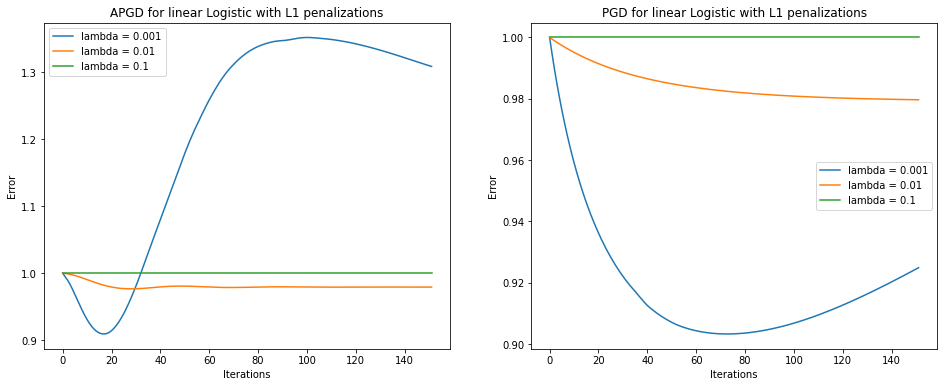

In [ ]:
n_iter = 150
#Impact of the penalization for APGD for logistic regression
lmbd1 = ['0.0001','0.001','0.01','0.1','1','10','100','1000']

A1, b1 = simu_logreg(coefs, n_samples=1000, corr=0.4)
L = smoothness_const_loreg(A1)


lambd1 = APGD(x0, loss_logreg, grad_logreg, L1_norm, prox_L1, 1/L, lmbd=0.001, n_iter = n_iter,x_true=coefs, verbose=True)
lambd2 = APGD(x0, loss_logreg, grad_logreg, L1_norm, prox_L1, 1/L, lmbd=0.01, n_iter = n_iter,x_true=coefs, verbose=True)
lambd3 = APGD(x0, loss_logreg, grad_logreg, L1_norm, prox_L1, 1/L, lmbd=0.1, n_iter = n_iter,x_true=coefs, verbose=True)

lambd4 = PGD(x0, loss_logreg, grad_logreg, L1_norm, prox_L1, 1/L, lmbd=0.001, n_iter = n_iter,x_true=coefs, verbose=True)
lambd5 = PGD(x0, loss_logreg, grad_logreg, L1_norm, prox_L1, 1/L, lmbd=0.01, n_iter = n_iter,x_true=coefs, verbose=True)
lambd6 = PGD(x0, loss_logreg, grad_logreg, L1_norm, prox_L1, 1/L, lmbd=0.1, n_iter = n_iter,x_true=coefs, verbose=True)

fig = plt.figure(figsize=(16,6))
ax = fig.add_subplot(1,2,1)
plt.plot(lambd1[2], label = 'lambda = 0.001')
plt.plot(lambd2[2], label = 'lambda = 0.01')
plt.plot(lambd3[2], label = 'lambda = 0.1')
plt.title('APGD for linear Logistic with L1 penalizations')
plt.xlabel('Iterations')
plt.ylabel('Error')
plt.legend()

ax = fig.add_subplot(1,2,2)
plt.plot(lambd4[2], label = 'lambda = 0.001')
plt.plot(lambd5[2], label = 'lambda = 0.01')
plt.plot(lambd6[2], label = 'lambda = 0.1')
plt.title('PGD for linear Logistic with L1 penalizations')
plt.xlabel('Iterations')
plt.ylabel('Error')
plt.legend()

plt.show()

Lauching APGD solver...
   it    |   obj    |   err   
       0 | 3.31e-02 | 9.93e-01
      10 | 1.87e-02 | 9.27e-01
      20 | 1.31e-02 | 9.12e-01
      30 | 1.20e-02 | 9.01e-01
      40 | 1.27e-02 | 8.90e-01
      50 | 1.34e-02 | 8.93e-01
      60 | 1.33e-02 | 8.98e-01
      70 | 1.31e-02 | 8.98e-01
      80 | 1.29e-02 | 8.96e-01
      90 | 1.30e-02 | 8.95e-01
     100 | 1.31e-02 | 8.94e-01
     110 | 1.31e-02 | 8.95e-01
     120 | 1.30e-02 | 8.96e-01
     130 | 1.30e-02 | 8.97e-01
     140 | 1.31e-02 | 8.96e-01
     150 | 1.31e-02 | 8.95e-01
Lauching APGD solver...
   it    |   obj    |   err   
       0 | 3.32e-02 | 9.94e-01
      10 | 2.58e-02 | 9.54e-01
      20 | 2.65e-02 | 9.57e-01
      30 | 2.63e-02 | 9.56e-01
      40 | 2.63e-02 | 9.57e-01
      50 | 2.63e-02 | 9.56e-01
      60 | 2.63e-02 | 9.57e-01
      70 | 2.63e-02 | 9.56e-01
      80 | 2.63e-02 | 9.57e-01
      90 | 2.63e-02 | 9.56e-01
     100 | 2.63e-02 | 9.57e-01
     110 | 2.63e-02 | 9.57e-01
     120 | 2.63e-02 | 

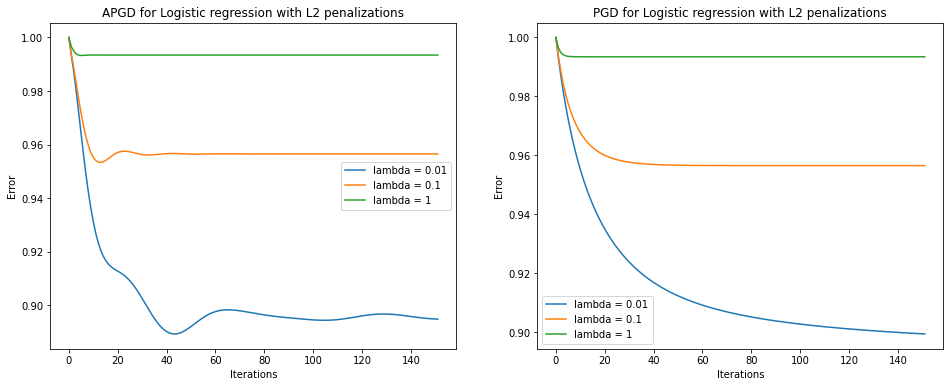

In [ ]:
n_iter = 150
#Impact of the penalization for APGD for logistic regression
lmbd1 = ['0.0001','0.001','0.01','0.1','1','10','100','1000']

A1, b1 = simu_logreg(coefs, n_samples=1000, corr=0.4)
L = smoothness_const_loreg(A1)


lambd1 = APGD(x0, loss_logreg, grad_logreg, L2_norm, prox_L2, 1/L, lmbd=0.01, n_iter = n_iter,x_true=coefs, verbose=True)
lambd2 = APGD(x0, loss_logreg, grad_logreg, L2_norm, prox_L2, 1/L, lmbd=0.1, n_iter = n_iter,x_true=coefs, verbose=True)
lambd3 = APGD(x0, loss_logreg, grad_logreg, L2_norm, prox_L2, 1/L, lmbd=1, n_iter = n_iter,x_true=coefs, verbose=True)

lambd4 = PGD(x0, loss_logreg, grad_logreg, L2_norm, prox_L2, 1/L, lmbd=0.01, n_iter = n_iter,x_true=coefs, verbose=True)
lambd5 = PGD(x0, loss_logreg, grad_logreg, L2_norm, prox_L2, 1/L, lmbd=0.1, n_iter = n_iter,x_true=coefs, verbose=True)
lambd6 = PGD(x0, loss_logreg, grad_logreg, L2_norm, prox_L2, 1/L, lmbd=1, n_iter = n_iter,x_true=coefs, verbose=True)

fig = plt.figure(figsize=(16,6))
ax = fig.add_subplot(1,2,1)
plt.plot(lambd1[2], label = 'lambda = 0.01')
plt.plot(lambd2[2], label = 'lambda = 0.1')
plt.plot(lambd3[2], label = 'lambda = 1')
plt.title('APGD for Logistic regression with L2 penalizations')
plt.xlabel('Iterations')
plt.ylabel('Error')
plt.legend()

ax = fig.add_subplot(1,2,2)
plt.plot(lambd4[2], label = 'lambda = 0.01')
plt.plot(lambd5[2], label = 'lambda = 0.1')
plt.plot(lambd6[2], label = 'lambda = 1')
plt.title('PGD for Logistic regression with L2 penalizations')
plt.xlabel('Iterations')
plt.ylabel('Error')

plt.legend()
plt.show()

Linear regression

Lauching APGD solver...
   it    |   obj    |   err   
       0 | 4.31e-01 | 9.38e-01
      10 | 3.27e-01 | 6.69e-01
      20 | 3.27e-01 | 6.89e-01
      30 | 3.27e-01 | 6.88e-01
      40 | 3.27e-01 | 6.87e-01
      50 | 3.27e-01 | 6.87e-01
      60 | 3.27e-01 | 6.87e-01
      70 | 3.27e-01 | 6.87e-01
      80 | 3.27e-01 | 6.87e-01
      90 | 3.27e-01 | 6.87e-01
     100 | 3.27e-01 | 6.87e-01
     110 | 3.27e-01 | 6.87e-01
     120 | 3.27e-01 | 6.87e-01
     130 | 3.27e-01 | 6.87e-01
     140 | 3.27e-01 | 6.87e-01
     150 | 3.27e-01 | 6.87e-01
Lauching APGD solver...
   it    |   obj    |   err   
       0 | 4.51e-01 | 9.51e-01
      10 | 3.63e-01 | 7.44e-01
      20 | 3.64e-01 | 7.59e-01
      30 | 3.64e-01 | 7.58e-01
      40 | 3.64e-01 | 7.58e-01
      50 | 3.64e-01 | 7.58e-01
      60 | 3.64e-01 | 7.58e-01
      70 | 3.64e-01 | 7.58e-01
      80 | 3.64e-01 | 7.58e-01
      90 | 3.64e-01 | 7.58e-01
     100 | 3.64e-01 | 7.58e-01
     110 | 3.64e-01 | 7.58e-01
     120 | 3.64e-01 | 

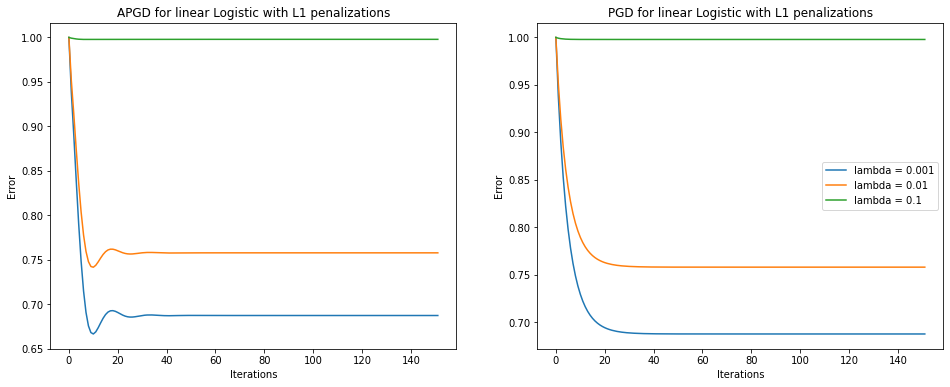

In [ ]:
n_iter = 150
#Impact of the penalization for APGD for logistic regression
lmbd1 = ['0.0001','0.001','0.01','0.1','1','10','100','1000']

A1, b1 = simu_linreg(coefs, n_samples=1000, corr=0.4)
L = smoothness_const_linreg(A1)


lambd1 = APGD(x0, loss_linreg, grad_linreg, L1_norm, prox_L1, 1/L, lmbd=0.001, n_iter = n_iter,x_true=coefs, verbose=True)
lambd2 = APGD(x0, loss_linreg, grad_linreg, L1_norm, prox_L1, 1/L, lmbd=0.01, n_iter = n_iter,x_true=coefs, verbose=True)
lambd3 = APGD(x0, loss_linreg, grad_linreg, L1_norm, prox_L1, 1/L, lmbd=0.1, n_iter = n_iter,x_true=coefs, verbose=True)

lambd4 = PGD(x0, loss_linreg, grad_linreg, L1_norm, prox_L1, 1/L, lmbd=0.001, n_iter = n_iter,x_true=coefs, verbose=True)
lambd5 = PGD(x0, loss_linreg, grad_linreg, L1_norm, prox_L1, 1/L, lmbd=0.01, n_iter = n_iter,x_true=coefs, verbose=True)
lambd6 = PGD(x0, loss_linreg, grad_linreg, L1_norm, prox_L1, 1/L, lmbd=0.1, n_iter = n_iter,x_true=coefs, verbose=True)

fig = plt.figure(figsize=(16,6))
ax = fig.add_subplot(1,2,1)
plt.plot(lambd1[2], label = 'lambda = 0.001')
plt.plot(lambd2[2], label = 'lambda = 0.01')
plt.plot(lambd3[2], label = 'lambda = 0.1')
plt.title('APGD for linear Logistic with L1 penalizations')
plt.xlabel('Iterations')
plt.ylabel('Error')

ax = fig.add_subplot(1,2,2)
plt.plot(lambd4[2], label = 'lambda = 0.001')
plt.plot(lambd5[2], label = 'lambda = 0.01')
plt.plot(lambd6[2], label = 'lambda = 0.1')
plt.title('PGD for linear Logistic with L1 penalizations')
plt.xlabel('Iterations')
plt.ylabel('Error')

plt.legend()
plt.show()

Lauching APGD solver...
   it    |   obj    |   err   
       0 | 1.18e+00 | 8.43e-01
      10 | 4.74e-01 | 1.38e-01
      20 | 4.69e-01 | 1.30e-01
      30 | 4.69e-01 | 1.26e-01
      40 | 4.69e-01 | 1.26e-01
      50 | 4.69e-01 | 1.26e-01
      60 | 4.69e-01 | 1.26e-01
      70 | 4.69e-01 | 1.26e-01
      80 | 4.69e-01 | 1.26e-01
      90 | 4.69e-01 | 1.26e-01
     100 | 4.69e-01 | 1.26e-01
     110 | 4.69e-01 | 1.26e-01
     120 | 4.69e-01 | 1.26e-01
     130 | 4.69e-01 | 1.26e-01
     140 | 4.69e-01 | 1.26e-01
     150 | 4.69e-01 | 1.26e-01
Lauching APGD solver...
   it    |   obj    |   err   
       0 | 1.18e+00 | 8.44e-01
      10 | 4.69e-01 | 1.24e-01
      20 | 4.75e-01 | 1.53e-01
      30 | 4.73e-01 | 1.43e-01
      40 | 4.73e-01 | 1.44e-01
      50 | 4.73e-01 | 1.44e-01
      60 | 4.73e-01 | 1.44e-01
      70 | 4.73e-01 | 1.44e-01
      80 | 4.73e-01 | 1.44e-01
      90 | 4.73e-01 | 1.44e-01
     100 | 4.73e-01 | 1.44e-01
     110 | 4.73e-01 | 1.44e-01
     120 | 4.73e-01 | 

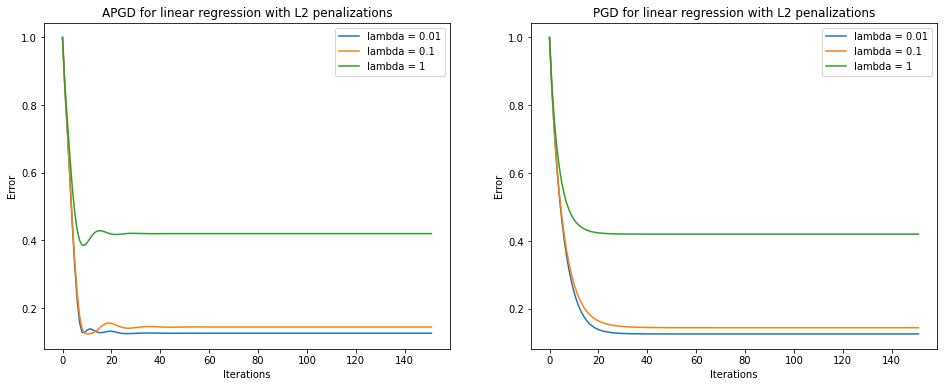

In [ ]:
n_iter = 150
#Impact of the L2 penalization for APGD for linear regression 
 
A0, b0 = simu_linreg(coefs, n_samples=1000, corr=0.4)
L = smoothness_const_linreg(A0)


lambd1 = APGD(x0, loss_linreg, grad_linreg, L2_norm, prox_L2, 1/L, lmbd=0.001, n_iter = n_iter,x_true=coefs, verbose=True)
lambd2 = APGD(x0, loss_linreg, grad_linreg, L2_norm, prox_L2, 1/L, lmbd=0.01, n_iter = n_iter,x_true=coefs, verbose=True)
lambd3 = APGD(x0, loss_linreg, grad_linreg, L2_norm, prox_L2, 1/L, lmbd=0.1, n_iter = n_iter,x_true=coefs, verbose=True)

lambd4 = PGD(x0, loss_linreg, grad_linreg, L2_norm, prox_L2, 1/L, lmbd=0.001, n_iter = n_iter,x_true=coefs, verbose=True)
lambd5 = PGD(x0, loss_linreg, grad_linreg, L2_norm, prox_L2, 1/L, lmbd=0.01, n_iter = n_iter,x_true=coefs, verbose=True)
lambd6 = PGD(x0, loss_linreg, grad_linreg, L2_norm, prox_L2, 1/L, lmbd=0.1, n_iter = n_iter,x_true=coefs, verbose=True)

x = np.arange(len(lambd1[1]))
fig = plt.figure(figsize=(16,6))
ax = fig.add_subplot(1,2,1)
plt.plot(x, lambd1[2], label = 'lambda = 0.01')
plt.plot(x, lambd2[2], label = 'lambda = 0.1')
plt.plot(x, lambd3[2], label = 'lambda = 1')
plt.title('APGD for linear regression with L2 penalizations')
plt.xlabel('Iterations')
plt.ylabel('Error')
plt.legend()


ax = fig.add_subplot(1,2,2)
plt.plot(x, lambd4[2], label = 'lambda = 0.01')
plt.plot(x, lambd5[2], label = 'lambda = 0.1')
plt.plot(x, lambd6[2], label = 'lambda = 1')
plt.title('PGD for linear regression with L2 penalizations')
plt.xlabel('Iterations')
plt.ylabel('Error')

plt.legend()
plt.show()